In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [104]:
stats = pd.read_csv('../data/lol_pro_stats/pro_stats.csv')

In [105]:
# stats 열 확인

stats.columns

Index(['Team', 'Player', 'Season', 'Champion', 'Game', 'Win', 'Lose',
       'WinRate', 'Kill', 'Death', 'Assist', 'KDA', 'VS', 'DMG', 'DPM', 'DTPM',
       'CS', 'CSPM', 'KPAR', 'DPAR', 'KS', 'Gold', 'GPM', 'Base'],
      dtype='object')

In [106]:
# 필요한 열만 추출

stats = stats[['Player', 'Season', 'Champion', 'Game', 'WinRate', 'KDA', 'DPM', 'DTPM', 'CSPM', 'KPAR', 'DPAR', 'KS', 'GPM']]
stats.head()

,Player,Season,Champion,Game,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM
0,Kiin,2019 LCK Spring,Aatrox,7,42.90%,2.60,330,646,9.26,36.80%,24.40%,20.20%,393
1,Kiin,2019 LCK Spring,Akali,4,50.00%,3.80,365,604,7.55,61.10%,18.60%,34.00%,393
2,Kiin,2019 LCK Spring,Ryze,4,25.00%,1.23,537,467,8.47,56.00%,29.70%,15.30%,373
3,Kiin,2019 LCK Spring,Lucian,3,33.30%,1.77,642,583,9.24,59.80%,36.80%,31.30%,414
4,Kiin,2019 LCK Spring,Vladimir,3,66.70%,6.25,502,692,9.32,49.50%,30.50%,22.20%,434


In [107]:
# 통합을 위해 % 기호 제거

stats['WinRate'] = stats['WinRate'].str.split(pat = "%").str[0].astype(float)
stats['KPAR'] = stats['KPAR'].str.split(pat = "%").str[0].astype(float)
stats['DPAR'] = stats['DPAR'].str.split(pat = "%").str[0].astype(float)
stats['KS'] = stats['KS'].str.split(pat = "%").str[0].astype(float)

In [108]:
# 새로운 데이터를 담을 데이터프레임 생성

grouped_stats = pd.DataFrame(columns=['Player', 'WinRate', 'KDA', 'DPM', 'DTPM', 'CSPM', 'KPAR', 'DPAR', 'KS', 'GPM'])

In [109]:
# 선수별로 통계를 가중평균한 데이터 생성

def group_by_player(df):
    def append_elements(df, columns):
        tmp = []
        for column in columns:
            tmp.append(np.average(df[df['Player']==player][column], weights=df[df['Player']==player]['Game']))
        return tmp
    for player in df['Player'].unique():
        
        if df[df['Player']==player]['Game'].sum() <= 10:
            continue
        
        stat = [player]
        stat.extend(append_elements(df, list(grouped_stats.columns)[1:]))
        grouped_stats.loc[len(grouped_stats),:] = stat
    return grouped_stats

In [110]:
group_by_player(stats).to_csv('../data/lol_pro_stats/grouped_pro_stats.csv', index=False)

In [113]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [129]:
grouped_stats.head()

,Player,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM
0,Kiin,44.9438,3.21236,412.124,602.573,8.60899,58.5247,24.9966,21.9697,393.82
1,Spirit,28.5714,2.34857,271.714,455.143,4.44929,74.1357,16.8,13.5786,286.429
2,Dread,47.6131,2.80607,219.536,724.452,4.84464,69.3524,13.1798,23.4726,320.94
3,Ucal,47.0603,3.44765,391.059,458.559,8.41706,63.7603,23.1162,22.3926,379.897
4,SSUN,39.9933,2.37067,330.2,470.133,7.81733,59.5867,21.3867,13.9867,349.333


In [131]:
grouped_stats_num = grouped_stats.set_index('Player')
grouped_stats_num.head()

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM
Player,,,,,,,,,
Kiin,44.9438,3.21236,412.124,602.573,8.60899,58.5247,24.9966,21.9697,393.82
Spirit,28.5714,2.34857,271.714,455.143,4.44929,74.1357,16.8,13.5786,286.429
Dread,47.6131,2.80607,219.536,724.452,4.84464,69.3524,13.1798,23.4726,320.94
Ucal,47.0603,3.44765,391.059,458.559,8.41706,63.7603,23.1162,22.3926,379.897
SSUN,39.9933,2.37067,330.2,470.133,7.81733,59.5867,21.3867,13.9867,349.333


In [117]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(grouped_stats.iloc[:, 1:])

C:\Users\Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [125]:
data_mean = np.mean(data_rescaled)
data_center = data_rescaled - data_mean
cov_matrix = np.cov(np.transpose(data_center))

In [126]:
eigenval, eigenvec = np.linalg.eig(cov_matrix)

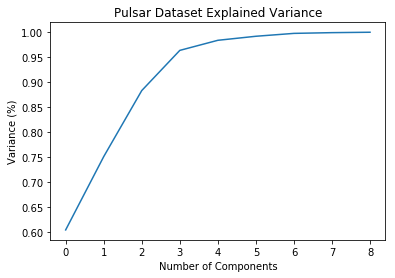

In [127]:
significance = [np.abs(i)/np.sum(eigenval) for i in eigenval]
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(significance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [132]:
pca = PCA(n_components=3)
pca.fit(grouped_stats_num)
pca_samples = pca.transform(grouped_stats_num)

In [133]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,60.119657,-136.200772,8.334159
1,-57.228337,60.512627,35.263796
2,-173.400037,-186.665524,-6.422462
3,82.612603,8.200788,4.843526
4,14.005313,19.331206,9.931322


In [134]:
tocluster = pd.DataFrame(ps[[0,1,2]])

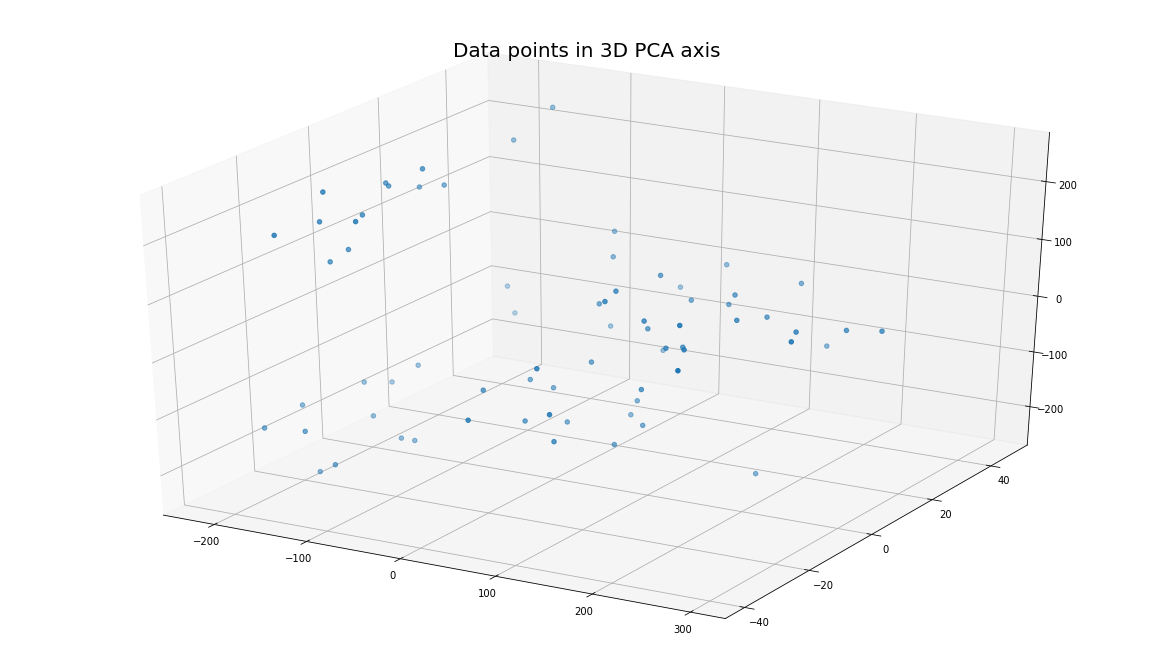

In [137]:
plt.rcParams['figure.figsize'] = (16, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

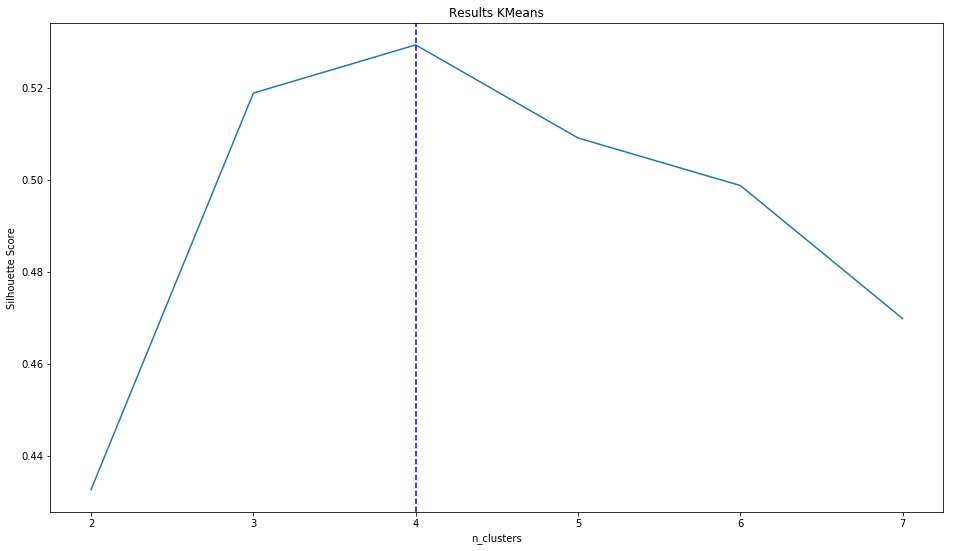

In [139]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

In [140]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[  36.53863094  -89.26756463    4.68492181]
 [-155.62626379  184.29079409    0.26126012]
 [ 161.03382142   43.54957108   -1.03757231]
 [-171.12705732 -162.57445302   -5.23312928]]


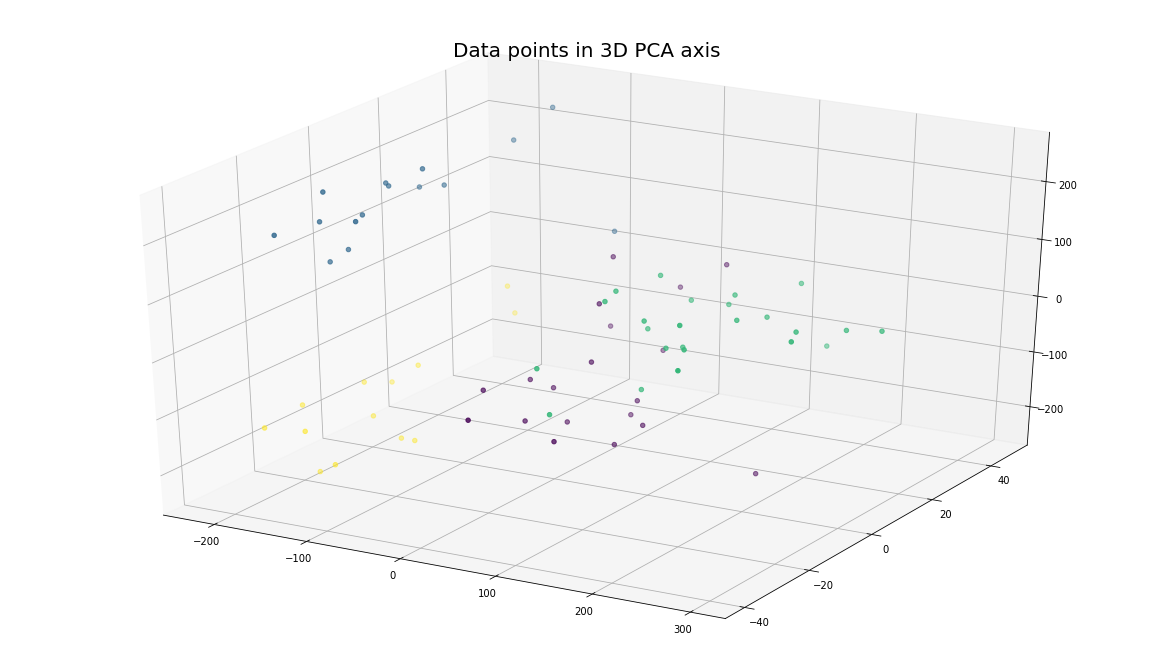

In [141]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

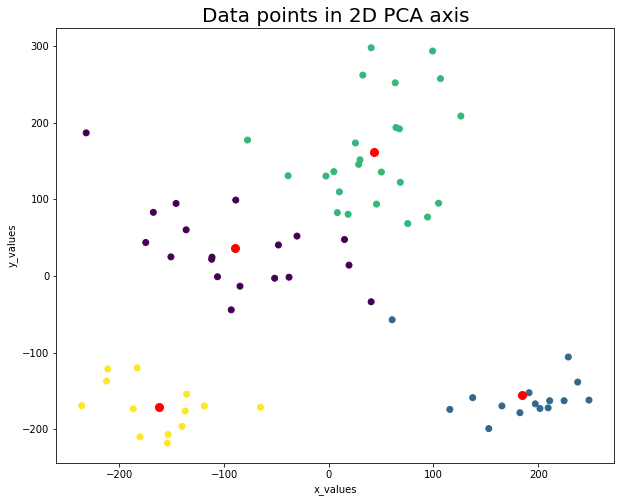

In [142]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

In [143]:
grouped_stats_num['cluster'] = c_preds


grouped_stats_num.head(10)

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM,cluster
Player,,,,,,,,,,
Kiin,44.9438,3.21236,412.124,602.573,8.60899,58.5247,24.9966,21.9697,393.82,0
Spirit,28.5714,2.34857,271.714,455.143,4.44929,74.1357,16.8,13.5786,286.429,1
Dread,47.6131,2.80607,219.536,724.452,4.84464,69.3524,13.1798,23.4726,320.94,3
Ucal,47.0603,3.44765,391.059,458.559,8.41706,63.7603,23.1162,22.3926,379.897,2
SSUN,39.9933,2.37067,330.2,470.133,7.81733,59.5867,21.3867,13.9867,349.333,0
Aiming,47.9987,5.58867,541.613,378.387,9.71653,69.456,32.3373,30.6387,440.147,2
Jelly,30.4348,2.07478,114.478,412.391,1.65739,60.5261,7.61739,3.91739,235.087,1
Senan,52.72,2.84582,124.564,357.873,1.32764,60.2127,7.82,4.81091,234.218,1
Nuguri,65.2847,3.69181,556.069,653.347,9.38806,64.7653,30.3375,27.5542,440.847,0


In [144]:
grouped_stats_num[grouped_stats_num['cluster'] == 0]

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM,cluster
Player,,,,,,,,,,
Kiin,44.9438,3.21236,412.124,602.573,8.60899,58.5247,24.9966,21.9697,393.82,0
SSUN,39.9933,2.37067,330.2,470.133,7.81733,59.5867,21.3867,13.9867,349.333,0
Nuguri,65.2847,3.69181,556.069,653.347,9.38806,64.7653,30.3375,27.5542,440.847,0
Flame,42.8571,5.98786,409.714,644.5,8.59429,57.4429,24.9714,19.5357,391.571,0
CuVee,46.9606,2.63379,366.606,525.091,8.32909,57.3909,24.0288,20.5758,379.652,0
Roach,44.8276,4.67379,315.172,540.897,8.86103,59.1655,19.8103,20.9103,394.103,0
Sword,75.8113,4.55468,359.194,503.532,8.86,53.2016,20.9645,19.2323,405.694,0
Doran,68.4211,6.02263,418.316,544,9.36947,56.3474,24.4526,29.6421,428.105,0
SoHwan,41.1706,3.46206,325.441,576.5,8.03853,57.0765,21.6559,21.0882,374.912,0


In [145]:
grouped_stats_num[grouped_stats_num['cluster'] == 1]

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM,cluster
Player,,,,,,,,,,
Spirit,28.5714,2.34857,271.714,455.143,4.44929,74.1357,16.8,13.5786,286.429,1
Jelly,30.4348,2.07478,114.478,412.391,1.65739,60.5261,7.61739,3.91739,235.087,1
Senan,52.72,2.84582,124.564,357.873,1.32764,60.2127,7.82,4.81091,234.218,1
Hoit,53.3267,4.35033,115.767,358.767,1.82667,68.8167,6.86333,3.5,268.7,1
BeryL,66.0661,4.24482,141.946,439.304,1.97339,66.6786,7.54286,5.55714,258.286,1
Life,45.4693,5.02614,140.182,312.25,1.48375,73.0193,9.37386,8.57614,250.216,1
Lehends,74.0728,10.8338,166.506,310.062,1.79864,67.9741,9.72716,5.5358,272.407,1
key,42.1639,3.06542,116.229,349.47,1.62554,69.7831,7.79759,8.78434,247.542,1
Nova,8.002,2.0372,128.04,377.88,1.8128,66.796,9.332,2.004,231.64,1


In [146]:
grouped_stats_num[grouped_stats_num['cluster'] == 2]

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM,cluster
Player,,,,,,,,,,
Ucal,47.0603,3.44765,391.059,458.559,8.41706,63.7603,23.1162,22.3926,379.897,2
Aiming,47.9987,5.58867,541.613,378.387,9.71653,69.456,32.3373,30.6387,440.147,2
ShowMaker,61.6209,8.24349,440.849,487.326,9.1093,68.55,24.3256,27.6151,415,2
Nuclear,61.1647,7.01494,453.282,305.388,9.83094,66.4071,25.2388,24.6953,437.129,2
Fly,43.8596,3.89,365.035,399.947,8.19526,61.1895,24.4123,18.5035,353.368,2
Kuzan,47.3632,6.60316,357.368,378.421,8.77263,67.4684,23.0368,20.6053,373.211,2
Ruler,45.4636,5.90568,513.307,351.193,10.4672,75.4989,33.2432,36.0375,452.955,2
Chovy,74.0728,15.1442,418.333,452.272,10.1064,60.3,24.3247,22.1926,433.148,2
Viper,74.0617,10.6567,495.654,307.778,10.6031,64.9395,28.8074,30.9395,468.37,2


In [147]:
grouped_stats_num[grouped_stats_num['cluster'] == 3]

,WinRate,KDA,DPM,DTPM,CSPM,KPAR,DPAR,KS,GPM,cluster
Player,,,,,,,,,,
Dread,47.6131,2.80607,219.536,724.452,4.84464,69.3524,13.1798,23.4726,320.94,3
Canyon,61.962,4.45113,264.535,737.761,4.99803,72.1704,14.1761,16.6859,325.704,3
Punch,59.9933,10.1987,177.2,686.933,5.20067,76.4,10.6867,16.0533,324.333,3
Peanut,45.8835,3.39094,166.176,707.482,5.16082,65.6541,10.7812,13.4565,310.694,3
Tarzan,74.0679,8.42383,260.58,703.716,5.5484,74.4358,15.3259,19.6346,348.593,3
bonO,44.0013,3.2708,185.667,704.187,4.40107,69.7413,12.1627,13.8747,294.973,3
Malrang,6.78136,2.79441,195.085,609.288,4.59254,74.0746,13.8169,25.3881,288.153,3
Seize,15.7895,2.05684,217.684,660.211,4.42263,65.1474,13.8368,18.8789,285.053,3
Score,34.9143,3.0854,207.46,678.81,4.64603,69.9349,13.3667,18.3429,304.381,3
